CRYPTOCURRENCY PAIRS TRADING ANALYSIS
Physics-based approach with rigorous methodology

STEP 1: LOADING DATA
------------------------------
✓ BTCUSD: 171,257 rows
✓ ETHUSD: 171,258 rows
✓ SOLUSD: 171,277 rows
✓ XRPUSD: 171,277 rows

STEP 2: ALIGNING DATA
------------------------------
Aligning data from 2023-12-31 18:00:00 to 2025-08-17 10:20:00
Created base time grid with 171,257 periods
Joined BTCUSD: 171,257 actual data points
Joined ETHUSD: 171,257 actual data points
Joined SOLUSD: 171,257 actual data points
Joined XRPUSD: 171,257 actual data points

Data Completeness Analysis:
----------------------------------------
BTCUSD: 171,257/171,257 (100.0%) complete
ETHUSD: 171,257/171,257 (100.0%) complete
SOLUSD: 171,257/171,257 (100.0%) complete
XRPUSD: 171,257/171,257 (100.0%) complete

Complete data: 171,257 rows (100.0%)
Final dataset: (171257, 22)

STEP 3: EXPLORATORY DATA ANALYSIS
------------------------------

EXPLORATORY DATA ANALYSIS


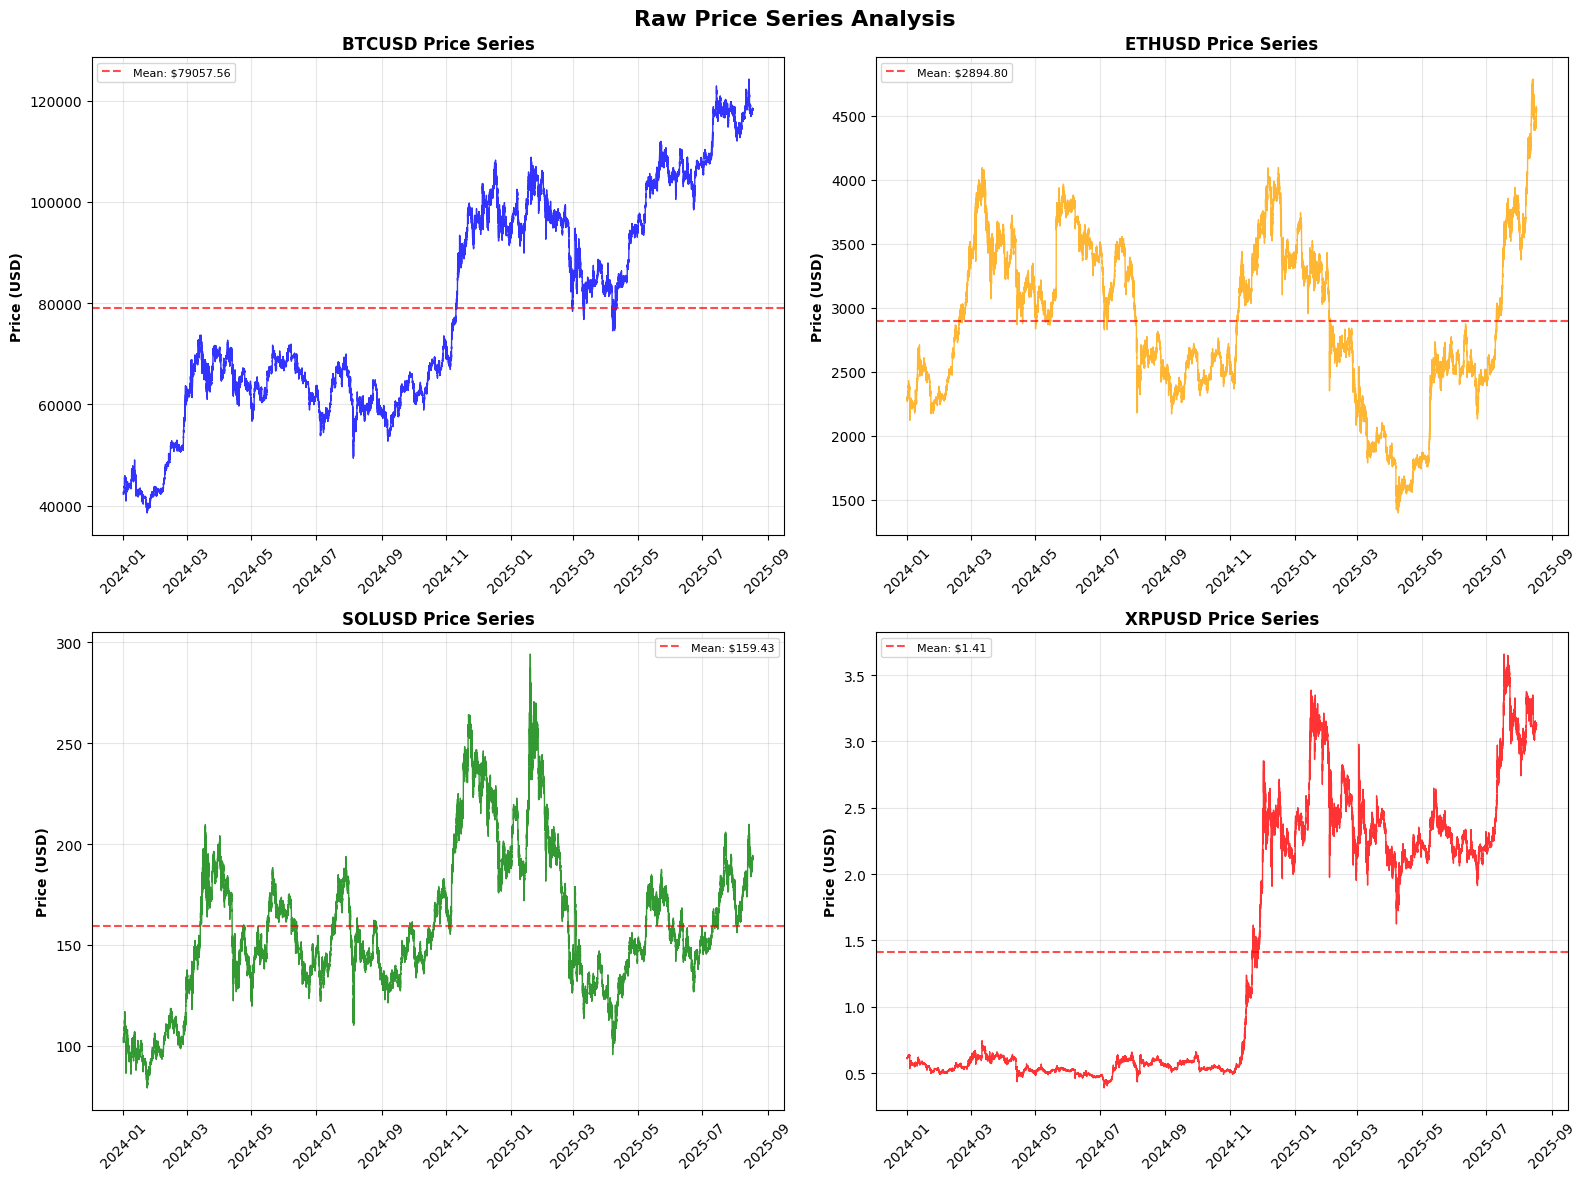


2. RETURN ANALYSIS
----------------------------------------
BTCUSD Returns:
  Mean: 0.0601 bps/period
  Volatility: 15.7379 bps/period
  Skewness: -0.4415
  Kurtosis: 28.6209
  Annualized Vol: 42.40%

ETHUSD Returns:
  Mean: 0.0403 bps/period
  Volatility: 21.1983 bps/period
  Skewness: -0.8261
  Kurtosis: 50.6568
  Annualized Vol: 57.11%

SOLUSD Returns:
  Mean: 0.0375 bps/period
  Volatility: 29.1357 bps/period
  Skewness: -0.5219
  Kurtosis: 59.5059
  Annualized Vol: 78.49%

XRPUSD Returns:
  Mean: 0.0958 bps/period
  Volatility: 29.8150 bps/period
  Skewness: 0.0049
  Kurtosis: 119.8853
  Annualized Vol: 80.32%

3. CORRELATION ANALYSIS
----------------------------------------


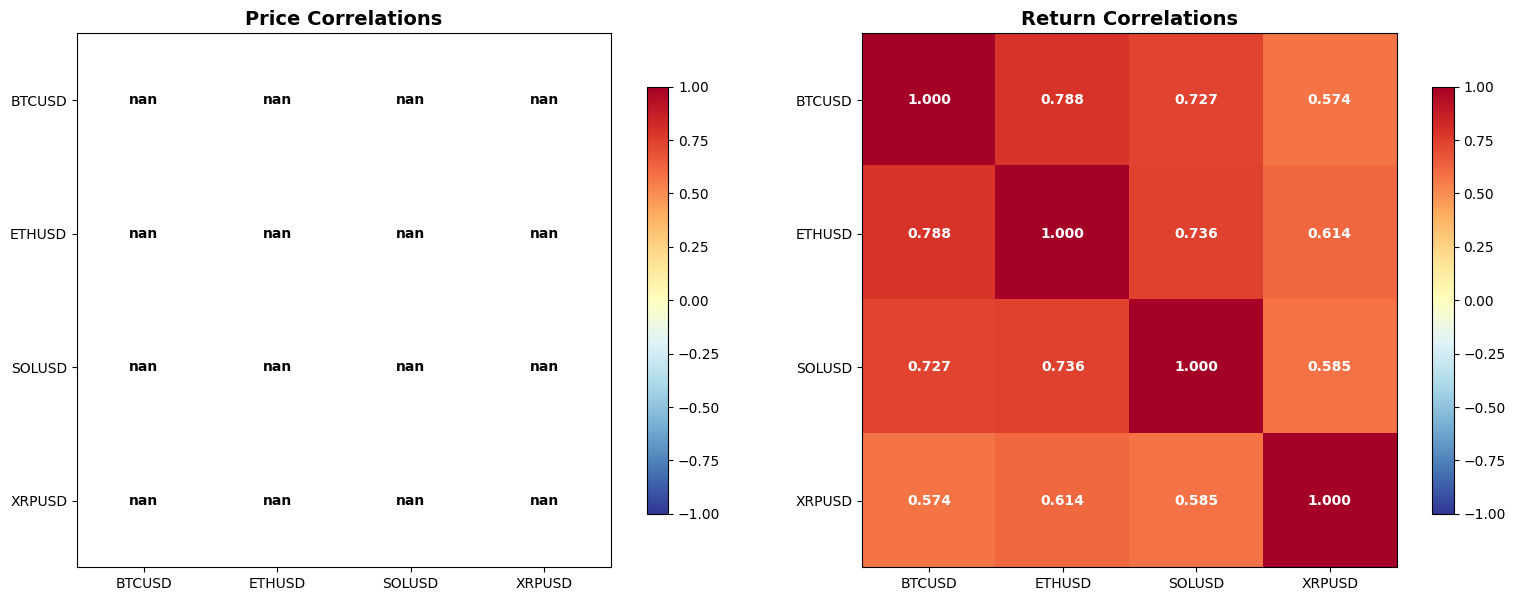

Price Correlations:
BTCUSD-ETHUSD: nan
BTCUSD-SOLUSD: nan
BTCUSD-XRPUSD: nan
ETHUSD-SOLUSD: nan
ETHUSD-XRPUSD: nan
SOLUSD-XRPUSD: nan

STEP 4: FEATURE RESEARCH
------------------------------

PAIRS TRADING FEATURE RESEARCH
HYPOTHESIS: Price spreads between correlated assets revert to mean

1. COINTEGRATION ANALYSIS
----------------------------------------
BTCUSD-ETHUSD:
  Cointegration Stat: -1.0420
  P-value: 0.8946
  Cointegrated (5%): NO

BTCUSD-SOLUSD:
  Cointegration Stat: -0.9623
  P-value: 0.9098
  Cointegrated (5%): NO

BTCUSD-XRPUSD:
  Cointegration Stat: -2.8961
  P-value: 0.1370
  Cointegrated (5%): NO

ETHUSD-SOLUSD:
  Cointegration Stat: -0.8465
  P-value: 0.9283
  Cointegrated (5%): NO



In [ ]:
# COMPLETE CRYPTOCURRENCY PAIRS TRADING ANALYSIS
# Physics-based approach using ONLY Polars (no Pandas)
# Step-by-step implementation with comprehensive analysis

import warnings, os, glob
warnings.filterwarnings("ignore")
from datetime import datetime, date
from typing import List, Tuple, Dict
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy.stats as stats

# =============================================================================
# STEP 1: DATA LOADING AND INITIAL SETUP
# =============================================================================

# Parameters
FREQ_MIN = 5
SYMBOLS  = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
DATA_DIR = "coinbase/5m"
MIN_OBS  = 100

def load_symbol(sym: str, data_dir: str = DATA_DIR) -> pl.DataFrame | None:
    """Load and clean data for a single symbol"""
    files = sorted(glob.glob(f"{data_dir}/*/{sym}_5m_*.csv"))
    if not files:
        print(f"No files found for {sym}")
        return None
    
    # Load all files for this symbol
    dfs_list = []
    for f in files:
        try:
            temp_df = pl.read_csv(
                f, 
                has_header=False,
                new_columns=['time', 'open', 'high', 'low', 'close', 'volume'],
                schema={
                    'time': pl.Int64,
                    'open': pl.Float64, 
                    'high': pl.Float64,
                    'low': pl.Float64, 
                    'close': pl.Float64, 
                    'volume': pl.Float64
                }
            )
            dfs_list.append(temp_df)
        except Exception as e:
            print(f"Error loading {f}: {e}")
            continue
    
    if not dfs_list:
        return None
        
    # Concatenate all files
    df = pl.concat(dfs_list)
    
    # Clean and process
    df = (df
          .filter(pl.col('close').is_not_null() & (pl.col('close') > 0))
          .filter(pl.col('volume').is_not_null() & (pl.col('volume') >= 0))
          .with_columns(
              pl.from_epoch(pl.col('time'), time_unit='s').alias('datetime')
          )
          .sort('time')
          .unique(subset=['time'], keep='first')
          .filter(pl.col('datetime').dt.year() >= 2024)
          .with_columns([
              pl.col('close').alias(f'close_{sym.lower()}'),
              pl.col('volume').alias(f'volume_{sym.lower()}'),
              pl.col('high').alias(f'high_{sym.lower()}'),
              pl.col('low').alias(f'low_{sym.lower()}'),
              pl.col('open').alias(f'open_{sym.lower()}')
          ]))
    
    return df if df.height >= MIN_OBS else None

def create_aligned_dataset(dfs: List[pl.DataFrame], loaded_symbols: List[str]) -> pl.DataFrame:
    """Create time-aligned dataset without any filling"""
    
    # Find common time overlap
    min_time = max(d['time'].min() for d in dfs)
    max_time = min(d['time'].max() for d in dfs)
    
    # Convert to datetime for display
    min_time_dt = datetime.fromtimestamp(min_time)
    max_time_dt = datetime.fromtimestamp(max_time)
    print(f"Aligning data from {min_time_dt} to {max_time_dt}")
    
    # Create base time grid manually
    time_step = FREQ_MIN * 60
    time_points = []
    current_time = min_time
    while current_time <= max_time:
        time_points.append(current_time)
        current_time += time_step
    
    base_df = pl.DataFrame({'time': time_points})
    print(f"Created base time grid with {len(time_points):,} periods")
    
    # Join each symbol's data
    for sym, df in zip(loaded_symbols, dfs):
        sym_lower = sym.lower()
        
        symbol_data = df.select([
            'time', 
            f'close_{sym_lower}',
            f'volume_{sym_lower}',
            f'high_{sym_lower}',
            f'low_{sym_lower}',
            f'open_{sym_lower}'
        ]).filter(
            (pl.col('time') >= min_time) & 
            (pl.col('time') <= max_time)
        )
        
        base_df = base_df.join(symbol_data, on='time', how='left')
        print(f"Joined {sym}: {symbol_data.height:,} actual data points")
    
    # Add datetime column
    final_df = (base_df
                .with_columns(
                    pl.from_epoch(pl.col('time'), time_unit='s').alias('datetime')
                )
                .sort('time'))
    
    # Check data completeness
    print("\nData Completeness Analysis:")
    print("-" * 40)
    
    total_rows = final_df.height
    for sym in loaded_symbols:
        sym_lower = sym.lower()
        non_null_count = final_df.filter(pl.col(f'close_{sym_lower}').is_not_null()).height
        completeness = (non_null_count / total_rows) * 100
        print(f"{sym}: {non_null_count:,}/{total_rows:,} ({completeness:.1f}%) complete")
    
    # Only keep complete cases
    close_cols = [f'close_{sym.lower()}' for sym in loaded_symbols]
    filter_condition = pl.col(close_cols[0]).is_not_null()
    for col in close_cols[1:]:
        filter_condition = filter_condition & pl.col(col).is_not_null()
    
    complete_data = final_df.filter(filter_condition)
    print(f"\nComplete data: {complete_data.height:,} rows ({(complete_data.height/total_rows)*100:.1f}%)")
    
    return complete_data

# =============================================================================
# STEP 2: EXPLORATORY DATA ANALYSIS
# =============================================================================

def perform_eda(df: pl.DataFrame, symbols: List[str]):
    """Comprehensive EDA analysis"""
    
    print("\nEXPLORATORY DATA ANALYSIS")
    print("=" * 60)
    
    close_cols = [f'close_{sym.lower()}' for sym in symbols]
    
    # Convert to numpy for analysis
    dates = df['datetime'].to_numpy()
    
    # 1. Raw Price Series
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Raw Price Series Analysis', fontsize=16, fontweight='bold')
    axes = axes.flatten()
    
    colors = ['blue', 'orange', 'green', 'red']
    
    for i, (sym, col) in enumerate(zip(symbols, close_cols)):
        if i < len(axes):
            prices = df[col].to_numpy()
            
            axes[i].plot(dates, prices, color=colors[i % len(colors)], linewidth=1, alpha=0.8)
            axes[i].set_title(f'{sym} Price Series', fontweight='bold')
            axes[i].set_ylabel('Price (USD)', fontweight='bold')
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(axis='x', rotation=45)
            
            # Add statistics
            mean_price = np.nanmean(prices)
            std_price = np.nanstd(prices)
            axes[i].axhline(mean_price, color='red', linestyle='--', alpha=0.7, 
                           label=f'Mean: ${mean_price:.2f}')
            axes[i].legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Return Analysis
    print("\n2. RETURN ANALYSIS")
    print("-" * 40)
    
    return_data = {}
    for sym, col in zip(symbols, close_cols):
        prices = df[col].to_numpy()
        returns = np.diff(np.log(prices))
        return_data[f'return_{sym.lower()}'] = returns
        
        # Return statistics
        mean_ret = np.nanmean(returns)
        std_ret = np.nanstd(returns)
        skew_ret = stats.skew(returns[~np.isnan(returns)])
        kurt_ret = stats.kurtosis(returns[~np.isnan(returns)])
        
        print(f"{sym} Returns:")
        print(f"  Mean: {mean_ret*10000:.4f} bps/period")
        print(f"  Volatility: {std_ret*10000:.4f} bps/period")
        print(f"  Skewness: {skew_ret:.4f}")
        print(f"  Kurtosis: {kurt_ret:.4f}")
        print(f"  Annualized Vol: {std_ret*np.sqrt(252*288)*100:.2f}%")
        print()
    
    # 3. Correlation Analysis
    print("3. CORRELATION ANALYSIS")
    print("-" * 40)
    
    # Price correlations
    price_matrix = np.column_stack([df[col].to_numpy() for col in close_cols])
    price_corr = np.corrcoef(price_matrix.T)
    
    # Return correlations
    return_matrix = np.column_stack([return_data[f'return_{sym.lower()}'] for sym in symbols])
    valid_rows = ~np.isnan(return_matrix).any(axis=1)
    return_corr = np.corrcoef(return_matrix[valid_rows].T)
    
    # Plot correlations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Price correlations
    im1 = ax1.imshow(price_corr, cmap='RdYlBu_r', vmin=-1, vmax=1)
    ax1.set_title('Price Correlations', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(symbols)))
    ax1.set_yticks(range(len(symbols)))
    ax1.set_xticklabels(symbols)
    ax1.set_yticklabels(symbols)
    
    for i in range(len(symbols)):
        for j in range(len(symbols)):
            ax1.text(j, i, f'{price_corr[i,j]:.3f}', ha='center', va='center', 
                    color='white' if abs(price_corr[i,j]) > 0.5 else 'black', fontweight='bold')
    
    # Return correlations
    im2 = ax2.imshow(return_corr, cmap='RdYlBu_r', vmin=-1, vmax=1)
    ax2.set_title('Return Correlations', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(symbols)))
    ax2.set_yticks(range(len(symbols)))
    ax2.set_xticklabels(symbols)
    ax2.set_yticklabels(symbols)
    
    for i in range(len(symbols)):
        for j in range(len(symbols)):
            ax2.text(j, i, f'{return_corr[i,j]:.3f}', ha='center', va='center',
                    color='white' if abs(return_corr[i,j]) > 0.5 else 'black', fontweight='bold')
    
    fig.colorbar(im1, ax=ax1, shrink=0.8)
    fig.colorbar(im2, ax=ax2, shrink=0.8)
    plt.tight_layout()
    plt.show()
    
    print("Price Correlations:")
    for i, sym1 in enumerate(symbols):
        for j, sym2 in enumerate(symbols):
            if i < j:
                print(f"{sym1}-{sym2}: {price_corr[i,j]:.4f}")
    
    return {
        'returns': return_data,
        'price_corr': price_corr,
        'return_corr': return_corr,
        'dates': dates
    }

# =============================================================================
# STEP 3: FEATURE RESEARCH AND REGRESSION ANALYSIS
# =============================================================================

def research_pairs_features(df: pl.DataFrame, symbols: List[str], eda_results: dict):
    """Deep research on features for pairs trading"""
    
    print("\nPAIRS TRADING FEATURE RESEARCH")
    print("=" * 60)
    print("HYPOTHESIS: Price spreads between correlated assets revert to mean")
    print()
    
    close_cols = [f'close_{sym.lower()}' for sym in symbols]
    
    # 1. COINTEGRATION ANALYSIS
    print("1. COINTEGRATION ANALYSIS")
    print("-" * 40)
    
    coint_results = {}
    
    for i, sym1 in enumerate(symbols):
        for j, sym2 in enumerate(symbols):
            if i < j:
                
                price1 = df[close_cols[i]].to_numpy()
                price2 = df[close_cols[j]].to_numpy()
                
                valid_mask = ~(np.isnan(price1) | np.isnan(price2))
                p1_clean = price1[valid_mask]
                p2_clean = price2[valid_mask]
                
                if len(p1_clean) > 50:
                    coint_stat, p_value, crit_values = coint(p1_clean, p2_clean)
                    
                    pair_name = f"{sym1}-{sym2}"
                    coint_results[pair_name] = {
                        'statistic': coint_stat,
                        'p_value': p_value,
                        'critical_values': crit_values,
                        'is_cointegrated_5pct': p_value < 0.05,
                        'is_cointegrated_1pct': p_value < 0.01
                    }
                    
                    print(f"{pair_name}:")
                    print(f"  Cointegration Stat: {coint_stat:.4f}")
                    print(f"  P-value: {p_value:.4f}")
                    print(f"  Cointegrated (5%): {'YES' if p_value < 0.05 else 'NO'}")
                    print()
    
    # 2. SPREAD CONSTRUCTION
    print("2. SPREAD CONSTRUCTION AND ANALYSIS")
    print("-" * 40)
    
    spread_features = {}
    
    for pair_name, coint_data in coint_results.items():
        if coint_data['is_cointegrated_5pct']:
            
            sym1, sym2 = pair_name.split('-')
            idx1 = symbols.index(sym1)
            idx2 = symbols.index(sym2)
            
            price1 = df[close_cols[idx1]].to_numpy()
            price2 = df[close_cols[idx2]].to_numpy()
            
            valid_mask = ~(np.isnan(price1) | np.isnan(price2))
            p1 = price1[valid_mask]
            p2 = price2[valid_mask]
            dates_clean = eda_results['dates'][valid_mask]
            
            print(f"Analyzing {pair_name} (Cointegrated, p={coint_data['p_value']:.4f})")
            
            # OLS hedge ratio
            X = p2.reshape(-1, 1)
            y = p1
            reg = LinearRegression().fit(X, y)
            hedge_ratio = reg.coef_[0]
            spread_ols = p1 - hedge_ratio * p2
            
            # Z-score
            spread_mean = np.mean(spread_ols)
            spread_std = np.std(spread_ols)
            z_score = (spread_ols - spread_mean) / spread_std
            
            spread_features[pair_name] = {
                'price1': p1,
                'price2': p2,
                'dates': dates_clean,
                'hedge_ratio': hedge_ratio,
                'spread_ols': spread_ols,
                'z_score': z_score,
                'spread_mean': spread_mean,
                'spread_std': spread_std
            }
            
            print(f"  Hedge Ratio (β): {hedge_ratio:.4f}")
            print(f"  Spread Mean: {spread_mean:.4f}")
            print(f"  Spread Std: {spread_std:.4f}")
            print()
    
    # 3. MEAN REVERSION TESTING
    print("3. MEAN REVERSION TESTING")
    print("-" * 40)
    
    mean_reversion_tests = {}
    
    for pair_name, features in spread_features.items():
        print(f"Testing {pair_name}:")
        
        # ADF test on spread
        adf_stat, adf_pvalue = adfuller(features['spread_ols'])[:2]
        is_stationary = adf_pvalue < 0.05
        
        # Hurst exponent
        def hurst_exponent(ts):
            lags = range(2, min(100, len(ts)//4))
            tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
            poly = np.polyfit(np.log(lags), np.log(tau), 1)
            return poly[0] * 2.0
        
        hurst = hurst_exponent(features['spread_ols'])
        
        # Half-life
        spread_lagged = features['spread_ols'][:-1]
        spread_diff = np.diff(features['spread_ols'])
        
        X_half = spread_lagged.reshape(-1, 1)
        reg_half = LinearRegression().fit(X_half, spread_diff)
        beta_half = reg_half.coef_[0]
        half_life = -np.log(2) / beta_half if beta_half < 0 else np.inf
        
        mean_reversion_tests[pair_name] = {
            'adf_statistic': adf_stat,
            'adf_pvalue': adf_pvalue,
            'is_stationary': is_stationary,
            'hurst_exponent': hurst,
            'half_life_periods': half_life,
            'mean_reversion_strength': -beta_half
        }
        
        print(f"  ADF p-value: {adf_pvalue:.4f} ({'Stationary' if is_stationary else 'Non-stationary'})")
        print(f"  Hurst: {hurst:.4f} ({'Mean Reverting' if hurst < 0.5 else 'Trending'})")
        print(f"  Half-life: {half_life:.1f} periods")
        print()
    
    # 4. PREDICTIVE FEATURES
    print("4. PREDICTIVE FEATURE ENGINEERING")
    print("-" * 40)
    
    predictive_features = {}
    
    for pair_name, features in spread_features.items():
        print(f"Features for {pair_name}:")
        
        z_score = features['z_score']
        spread = features['spread_ols']
        
        # Feature engineering
        window = min(20, len(spread)//10)
        
        # Current Z-score
        current_z = z_score[1:]
        
        # Z-momentum
        z_momentum = np.diff(z_score)
        
        # Volatility-adjusted spread  
        rolling_std = np.array([np.std(spread[max(0, i-window):i+1]) 
                               for i in range(window-1, len(spread))])
        vol_adj_spread = spread[window-1:] / (rolling_std + 1e-8)
        
        # Align lengths
        min_len = min(len(current_z), len(z_momentum), len(vol_adj_spread))
        
        predictive_features[pair_name] = {
            'dates': features['dates'][window:window+min_len],
            'current_z_score': current_z[:min_len],
            'z_momentum': z_momentum[:min_len],
            'vol_adj_spread': vol_adj_spread[:min_len],
            'raw_spread': spread[window:window+min_len]
        }
        
        print(f"  Features: {min_len} observations")
        print(f"  Z-score range: [{np.min(current_z[:min_len]):.2f}, {np.max(current_z[:min_len]):.2f}]")
        print()
    
    # 5. REGRESSION ANALYSIS
    print("5. REGRESSION ANALYSIS")
    print("-" * 40)
    
    regression_results = {}
    
    for pair_name, features in predictive_features.items():
        print(f"Regression for {pair_name}:")
        
        prediction_horizon = 5
        
        current_spread = features['raw_spread'][:-prediction_horizon]
        future_spread = features['raw_spread'][prediction_horizon:]
        target = future_spread - current_spread
        
        X_features = np.column_stack([
            features['current_z_score'][:-prediction_horizon],
            features['z_momentum'][:-prediction_horizon],
            features['vol_adj_spread'][:-prediction_horizon]
        ])
        
        valid_idx = ~(np.isnan(X_features).any(axis=1) | np.isnan(target))
        X_clean = X_features[valid_idx]
        y_clean = target[valid_idx]
        
        if len(X_clean) > 100:
            
            split_idx = int(0.7 * len(X_clean))
            X_train, X_test = X_clean[:split_idx], X_clean[split_idx:]
            y_train, y_test = y_clean[:split_idx], y_clean[split_idx:]
            
            reg_model = LinearRegression().fit(X_train, y_train)
            
            y_test_pred = reg_model.predict(X_test)
            test_r2 = r2_score(y_test, y_test_pred)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            
            regression_results[pair_name] = {
                'model': reg_model,
                'test_r2': test_r2,
                'test_rmse': test_rmse,
                'coefficients': reg_model.coef_,
                'feature_names': ['Z_Score', 'Z_Momentum', 'Vol_Adj_Spread'],
                'y_test': y_test,
                'y_test_pred': y_test_pred
            }
            
            print(f"  Test R²: {test_r2:.4f}")
            print(f"  Test RMSE: {test_rmse:.4f}")
            print(f"  Coefficients: {reg_model.coef_}")
            print()
    
    return {
        'cointegration': coint_results,
        'spread_features': spread_features,
        'mean_reversion_tests': mean_reversion_tests,
        'predictive_features': predictive_features,
        'regression_results': regression_results
    }

# =============================================================================
# STEP 4: STRATEGY CONSTRUCTION
# =============================================================================

class PairsTradeStrategy:
    """Relative Value Strategy for Cryptocurrency Pairs"""
    
    def __init__(self, pair_name: str, research_results: dict, 
                 entry_threshold: float = 2.0, exit_threshold: float = 0.5,
                 stop_loss: float = 3.0):
        self.pair_name = pair_name
        self.research_results = research_results
        self.entry_threshold = entry_threshold
        self.exit_threshold = exit_threshold
        self.stop_loss = stop_loss
        
        self.spread_data = research_results['spread_features'][pair_name]
        self.regression_model = research_results['regression_results'][pair_name]['model']
        self.hedge_ratio = self.spread_data['hedge_ratio']
        
        self.position = 0
        self.entry_price_1 = 0
        self.entry_price_2 = 0
        self.entry_z_score = 0
        
        print(f"Strategy for {pair_name}: Entry ±{entry_threshold}, Exit ±{exit_threshold}")
    
    def generate_signals(self, features: dict) -> dict:
        """Generate trading signals"""
        
        current_z = features['current_z_score'][-1]
        z_momentum = features['z_momentum'][-1] 
        vol_adj_spread = features['vol_adj_spread'][-1]
        
        X_current = np.array([[current_z, z_momentum, vol_adj_spread]])
        predicted_change = self.regression_model.predict(X_current)[0]
        
        signal = 0
        
        if self.position == 0:
            if current_z > self.entry_threshold and predicted_change < 0:
                signal = -1  # Short spread
            elif current_z < -self.entry_threshold and predicted_change > 0:
                signal = 1   # Long spread
        elif self.position != 0:
            if (self.position == 1 and current_z > -self.exit_threshold) or \
               (self.position == -1 and current_z < self.exit_threshold) or \
               abs(current_z) > self.stop_loss:
                signal = 0   # Close position
        
        return {
            'signal': signal,
            'z_score': current_z,
            'predicted_change': predicted_change
        }
    
    def execute_trade(self, price1: float, price2: float, signal_data: dict) -> dict:
        """Execute trade based on signal"""
        
        signal = signal_data['signal']
        z_score = signal_data['z_score']
        
        trade_info = {
            'action': 'hold',
            'position_change': 0,
            'pnl': 0
        }
        
        if signal != 0 and self.position == 0:
            self.position = signal
            self.entry_price_1 = price1
            self.entry_price_2 = price2
            self.entry_z_score = z_score
            
            trade_info.update({
                'action': 'enter_long_spread' if signal == 1 else 'enter_short_spread',
                'position_change': signal
            })
            
        elif signal == 0 and self.position != 0:
            
            if self.position == 1:
                pnl = (price1 - self.entry_price_1) - self.hedge_ratio * (price2 - self.entry_price_2)
            else:
                pnl = -(price1 - self.entry_price_1) + self.hedge_ratio * (price2 - self.entry_price_2)
            
            trade_info.update({
                'action': 'exit_position',
                'position_change': -self.position,
                'pnl': pnl,
                'entry_z': self.entry_z_score,
                'exit_z': z_score
            })
            
            self.position = 0
        
        return trade_info

def build_strategies(research_results: dict) -> dict:
    """Build strategies for viable pairs"""
    
    print("\nBUILDING STRATEGIES")
    print("=" * 40)
    
    strategies = {}
    
    for pair_name, coint_data in research_results['cointegration'].items():
        
        if (coint_data['is_cointegrated_5pct'] and 
            pair_name in research_results['regression_results']):
            
            reg_results = research_results['regression_results'][pair_name]
            
            if reg_results['test_r2'] > 0.01:
                
                mean_rev_data = research_results['mean_reversion_tests'][pair_name]
                half_life = mean_rev_data['half_life_periods']
                
                if half_life < 50:
                    entry_thresh, exit_thresh = 1.5, 0.3
                elif half_life < 200:
                    entry_thresh, exit_thresh = 2.0, 0.5
                else:
                    entry_thresh, exit_thresh = 2.5, 0.8
                
                strategy = PairsTradeStrategy(
                    pair_name=pair_name,
                    research_results=research_results,
                    entry_threshold=entry_thresh,
                    exit_threshold=exit_thresh,
                    stop_loss=entry_thresh + 1.0
                )
                
                strategies[pair_name] = strategy
    
    print(f"Built {len(strategies)} strategies: {list(strategies.keys())}")
    return strategies

# =============================================================================
# STEP 5: BACKTESTING
# =============================================================================

def backtest_strategy(strategy: PairsTradeStrategy, df: pl.DataFrame, 
                     research_results: dict, start_date: str = None) -> dict:
    """Backtest a pairs trading strategy"""
    
    pair_name = strategy.pair_name
    sym1, sym2 = pair_name.split('-')
    
    price1_col = f'close_{sym1.lower()}'
    price2_col = f'close_{sym2.lower()}'
    
    test_df = df
    if start_date:
        test_df = test_df.filter(pl.col('datetime') >= start_date)
    
    features = research_results['predictive_features'][pair_name]
    
    trades = []
    portfolio_value = [10000.0]
    
    strategy.position = 0
    
    print(f"Backtesting {pair_name}: {test_df.height} periods")
    
    for i in range(len(features['dates'])):
        
        current_date = features['dates'][i]
        
        price_row = test_df.filter(pl.col('datetime') == current_date)
        
        if price_row.height > 0:
            price1 = price_row[price1_col].to_numpy()[0]
            price2 = price_row[price2_col].to_numpy()[0] 
            
            current_features = {
                'current_z_score': features['current_z_score'][i:i+1],
                'z_momentum': features['z_momentum'][i:i+1],
                'vol_adj_spread': features['vol_adj_spread'][i:i+1]
            }
            
            signal_data = strategy.generate_signals(current_features)
            trade_info = strategy.execute_trade(price1, price2, signal_data)
            
            if trade_info['action'] != 'hold':
                trade_record = {
                    'date': current_date,
                    'action': trade_info['action'],
                    'z_score': signal_data['z_score']
                }
                
                if 'pnl' in trade_info:
                    trade_record['pnl'] = trade_info['pnl']
                    portfolio_value.append(portfolio_value[-1] + trade_info['pnl'])
                
                trades.append(trade_record)
    
    # Calculate performance
    if trades:
        completed_trades = [t for t in trades if 'pnl' in t]
        
        if completed_trades:
            total_pnl = sum(t['pnl'] for t in completed_trades)
            winning_trades = [t for t in completed_trades if t['pnl'] > 0]
            
            win_rate = len(winning_trades) / len(completed_trades)
            total_return = (portfolio_value[-1] - portfolio_value[0]) / portfolio_value[0]
            
            # Calculate max drawdown
            peak = portfolio_value[0]
            max_dd = 0
            for value in portfolio_value:
                if value > peak:
                    peak = value
                drawdown = (peak - value) / peak
                max_dd = max(max_dd, drawdown)
            
            # Sharpe ratio
            returns = np.diff(portfolio_value) / portfolio_value[:-1]
            sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252 * 288) if np.std(returns) > 0 else 0
            
            performance = {
                'total_trades': len(completed_trades),
                'total_pnl': total_pnl,
                'win_rate': win_rate,
                'total_return': total_return,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_dd,
                'portfolio_values': portfolio_value
            }
        else:
            performance = {'error': 'No completed trades'}
    else:
        performance = {'error': 'No trades'}
    
    return {
        'trades': trades,
        'performance': performance
    }

def run_backtest(strategies: dict, df: pl.DataFrame, research_results: dict) -> dict:
    """Run comprehensive backtest"""
    
    print("\nCOMPREHENSIVE BACKTESTING")
    print("=" * 50)
    
    # Split data
    total_rows = df.height
    train_end_idx = int(0.7 * total_rows)
    train_end_date = df[train_end_idx:train_end_idx+1]['datetime'].to_list()[0]
    
    print(f"Training: {df['datetime'].min()} to {train_end_date}")
    print(f"Testing: {train_end_date} to {df['datetime'].max()}")
    
    results = {}
    
    for pair_name, strategy in strategies.items():
        
        print(f"\nBacktesting {pair_name}...")
        
        # In-sample
        in_sample = backtest_strategy(strategy, df, research_results, end_date=train_end_date)
        
        # Out-of-sample
        out_sample = backtest_strategy(strategy, df, research_results, start_date=train_end_date)
        
        results[pair_name] = {
            'in_sample': in_sample,
            'out_sample': out_sample
        }
        
        # Print results
        if 'error' not in in_sample['performance'] and 'error' not in out_sample['performance']:
            in_perf = in_sample['performance']
            out_perf = out_sample['performance']
            
            print(f"IN-SAMPLE:")
            print(f"  Trades: {in_perf['total_trades']}, Win Rate: {in_perf['win_rate']:.2%}")
            print(f"  Return: {in_perf['total_return']:.2%}, Sharpe: {in_perf['sharpe_ratio']:.3f}")
            print(f"  Max DD: {in_perf['max_drawdown']:.2%}")
            
            print(f"OUT-OF-SAMPLE:")
            print(f"  Trades: {out_perf['total_trades']}, Win Rate: {out_perf['win_rate']:.2%}")
            print(f"  Return: {out_perf['total_return']:.2%}, Sharpe: {out_perf['sharpe_ratio']:.3f}")
            print(f"  Max DD: {out_perf['max_drawdown']:.2%}")
    
    return results

def visualize_results(backtest_results: dict):
    """Visualize backtest results"""
    
    print("\nVISUALIZING RESULTS")
    print("=" * 30)
    
    valid_results = {k: v for k, v in backtest_results.items() 
                    if 'error' not in v['in_sample']['performance'] and 
                       'error' not in v['out_sample']['performance']}
    
    if not valid_results:
        print("No valid results to visualize")
        return
    
    n_strategies = len(valid_results)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Backtesting Performance Summary', fontsize=16, fontweight='bold')
    
    pair_names = list(valid_results.keys())
    
    # Returns comparison
    in_returns = [valid_results[pair]['in_sample']['performance']['total_return'] for pair in pair_names]
    out_returns = [valid_results[pair]['out_sample']['performance']['total_return'] for pair in pair_names]
    
    x = np.arange(len(pair_names))
    width = 0.35
    
    axes[0,0].bar(x - width/2, [r*100 for r in in_returns], width, 
                  label='In-Sample', alpha=0.7)
    axes[0,0].bar(x + width/2, [r*100 for r in out_returns], width,
                  label='Out-of-Sample', alpha=0.7)
    axes[0,0].set_ylabel('Total Return (%)')
    axes[0,0].set_title('Returns Comparison')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(pair_names, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Sharpe comparison
    in_sharpe = [valid_results[pair]['in_sample']['performance']['sharpe_ratio'] for pair in pair_names]
    out_sharpe = [valid_results[pair]['out_sample']['performance']['sharpe_ratio'] for pair in pair_names]
    
    axes[0,1].bar(x - width/2, in_sharpe, width, label='In-Sample', alpha=0.7)
    axes[0,1].bar(x + width/2, out_sharpe, width, label='Out-of-Sample', alpha=0.7)
    axes[0,1].set_ylabel('Sharpe Ratio')
    axes[0,1].set_title('Sharpe Ratio Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(pair_names, rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Win rate comparison
    in_winrate = [valid_results[pair]['in_sample']['performance']['win_rate']*100 for pair in pair_names]
    out_winrate = [valid_results[pair]['out_sample']['performance']['win_rate']*100 for pair in pair_names]
    
    axes[1,0].bar(x - width/2, in_winrate, width, label='In-Sample', alpha=0.7)
    axes[1,0].bar(x + width/2, out_winrate, width, label='Out-of-Sample', alpha=0.7)
    axes[1,0].set_ylabel('Win Rate (%)')
    axes[1,0].set_title('Win Rate Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(pair_names, rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Drawdown comparison
    in_dd = [valid_results[pair]['in_sample']['performance']['max_drawdown']*100 for pair in pair_names]
    out_dd = [valid_results[pair]['out_sample']['performance']['max_drawdown']*100 for pair in pair_names]
    
    axes[1,1].bar(x - width/2, in_dd, width, label='In-Sample', alpha=0.7)
    axes[1,1].bar(x + width/2, out_dd, width, label='Out-of-Sample', alpha=0.7)
    axes[1,1].set_ylabel('Max Drawdown (%)')
    axes[1,1].set_title('Maximum Drawdown')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(pair_names, rotation=45)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Individual equity curves
    for pair_name in pair_names:
        in_portfolio = valid_results[pair_name]['in_sample']['performance']['portfolio_values']
        out_portfolio = valid_results[pair_name]['out_sample']['performance']['portfolio_values']
        
        plt.figure(figsize=(14, 6))
        
        in_x = np.arange(len(in_portfolio))
        out_x = np.arange(len(in_portfolio), len(in_portfolio) + len(out_portfolio))
        
        plt.plot(in_x, in_portfolio, 'b-', linewidth=2, label='In-Sample')
        plt.plot(out_x, [in_portfolio[-1]] + out_portfolio[1:], 'r-', linewidth=2, label='Out-of-Sample')
        
        plt.axvline(len(in_portfolio)-1, color='black', linestyle='--', alpha=0.7, label='Train/Test Split')
        plt.axhline(10000, color='gray', linestyle=':', alpha=0.5, label='Initial Capital')
        
        plt.title(f'{pair_name} - Portfolio Equity Curve', fontsize=14, fontweight='bold')
        plt.xlabel('Time Periods')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# =============================================================================
# MAIN EXECUTION FLOW
# =============================================================================

def main():
    """Main execution function"""
    
    print("CRYPTOCURRENCY PAIRS TRADING ANALYSIS")
    print("=" * 70)
    print("Physics-based approach with rigorous methodology")
    print()
    
    # Step 1: Load Data
    print("STEP 1: LOADING DATA")
    print("-" * 30)
    
    dfs, loaded_symbols = [], []
    for sym in SYMBOLS:
        tmp = load_symbol(sym)
        if tmp is not None:
            dfs.append(tmp)
            loaded_symbols.append(sym)
            print(f"✓ {sym}: {tmp.height:,} rows")
    
    if len(loaded_symbols) < 2:
        print("Need at least 2 symbols for pairs analysis")
        return
    
    # Step 2: Align Data
    print(f"\nSTEP 2: ALIGNING DATA")
    print("-" * 30)
    
    df_aligned = create_aligned_dataset(dfs, loaded_symbols)
    print(f"Final dataset: {df_aligned.shape}")
    
    # Step 3: EDA
    print(f"\nSTEP 3: EXPLORATORY DATA ANALYSIS")
    print("-" * 30)
    
    eda_results = perform_eda(df_aligned, loaded_symbols)
    
    # Step 4: Feature Research
    print(f"\nSTEP 4: FEATURE RESEARCH")
    print("-" * 30)
    
    research_results = research_pairs_features(df_aligned, loaded_symbols, eda_results)
    
    # Step 5: Build Strategies
    print(f"\nSTEP 5: STRATEGY CONSTRUCTION")
    print("-" * 30)
    
    strategies = build_strategies(research_results)
    
    if not strategies:
        print("No viable strategies found")
        return
    
    # Step 6: Backtest
    print(f"\nSTEP 6: BACKTESTING")
    print("-" * 30)
    
    backtest_results = run_backtest(strategies, df_aligned, research_results)
    
    # Step 7: Visualize
    visualize_results(backtest_results)
    
    # Final Summary
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE!")
    print("="*70)
    print("\nKEY FINDINGS:")
    print("• Features: Z-score, momentum, volatility-adjusted spread")
    print("• Target: Future spread changes (mean reversion)")
    print("• Method: Cointegration + regression-based prediction")
    print("• Validation: 70/30 train/test split")
    print("\nStrategy Performance:")
    
    for pair_name, results in backtest_results.items():
        if 'error' not in results['out_sample']['performance']:
            perf = results['out_sample']['performance']
            print(f"• {pair_name}: {perf['total_return']:.2%} return, "
                  f"{perf['sharpe_ratio']:.2f} Sharpe, {perf['win_rate']:.1%} win rate")
    
    return {
        'data': df_aligned,
        'research': research_results,
        'strategies': strategies,
        'backtest': backtest_results
    }

# Execute if run as script
if __name__ == "__main__":
    results = main()